In [ ]:
!wget 'https://www.researchgate.net/profile/Torsten-Seemann/publication/239545029/figure/fig4/AS:669380883017729@1536604247030/a-low-contrast-image-b-after-enhancement_Q320.jpg'
!wget 'https://i.stack.imgur.com/WYrct.png'
!wget 'https://p0.pikrepo.com/preview/55/263/grayscale-photo-of-albert-einstein.jpg'
lena = 'a-low-contrast-image-b-after-enhancement_Q320.jpg'
photographer = 'WYrct.png'
einstein = 'grayscale-photo-of-albert-einstein.jpg'

--2021-10-28 07:44:37--  https://www.researchgate.net/profile/Torsten-Seemann/publication/239545029/figure/fig4/AS:669380883017729@1536604247030/a-low-contrast-image-b-after-enhancement_Q320.jpg
Resolving www.researchgate.net (www.researchgate.net)... 104.17.32.105, 104.17.33.105, 2606:4700::6811:2069, ...
Connecting to www.researchgate.net (www.researchgate.net)|104.17.32.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5845 (5.7K) [image/jpeg]
Saving to: ‘a-low-contrast-image-b-after-enhancement_Q320.jpg.2’

a-low-contrast-imag 100%[===================>]   5.71K  --.-KB/s    in 0s      

2021-10-28 07:44:37 (69.8 MB/s) - ‘a-low-contrast-image-b-after-enhancement_Q320.jpg.2’ saved [5845/5845]

--2021-10-28 07:44:38--  https://i.stack.imgur.com/WYrct.png
Resolving i.stack.imgur.com (i.stack.imgur.com)... 151.101.248.193
Connecting to i.stack.imgur.com (i.stack.imgur.com)|151.101.248.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
plt.rcParams.update({'font.size': 10,
                     'legend.fontsize': 12,
                     'legend.title_fontsize': 12,})
# plt.style.use('seaborn')

N_GRAY_LEVEL = 256


def histogram(img, display=False):
    hist = [0 for _ in range(N_GRAY_LEVEL)]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1
    normalized_hist = [h/(img.shape[0]*img.shape[1]) for h in hist]
    if display==True:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))
        ax2.bar([x for x in range(N_GRAY_LEVEL)], normalized_hist)
        ax2.set_title('Histogram')
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Input Image')
        plt.tight_layout()
        plt.savefig('histogram.jpg')
        plt.show()
    return normalized_hist, hist

def histogram_equalization(img, display=False):
    hist, _ = histogram(img)
    T = []
    for i in range(len(hist)):
        s = sum(hist[:i+1])
        T.append(int((N_GRAY_LEVEL-1)*s))

    equ_image = np.zeros_like(img)
    for r in range(len(T)):
        idx = img==r
        equ_image[idx] = T[r]

    hequ, _ = histogram(equ_image)
    if display==True:
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].set_title('Input Image')
        ax[1, 0].imshow(equ_image, cmap='gray')
        ax[1, 0].set_title('Equalized Image')
        x = [x for x in range(N_GRAY_LEVEL)]
        ax[0, 1].bar(x, hist)
        ax[0, 1].set_title('Input Histogram')
        ax[1, 1].bar(x, hequ)
        ax[1, 1].set_title('Equalized Histogram')
        plt.tight_layout()
        plt.savefig('histogram_equalization.jpg')
        plt.show()

    return equ_image, hequ, T


def histogram_specification(source_img,
	                        reference_img,
	                        display=False,
	                        display_transformations=False):

    source_hist, _ = histogram(source_img)
    reference_hist, _ = histogram(reference_img)
    equ_source_img, _, T = histogram_equalization(source_img)
    equ_reference_img, _, G = histogram_equalization(reference_img)
    spec_image = np.zeros_like(source_img)

    H = np.zeros_like(T)
    T = np.array(T)
    G = np.array(G)
    spec_image = equ_source_img.copy()
    for s in T:
        idx = np.where(G==s)[0]
        if len(idx)==0:
            i = 1
            while(len(idx)==0):
                idx = np.where(G==s-i)[0]
                if len(idx==0):
                    idx = np.where(G==s+i)[0]
                i += 1
                if (s-i)==0 or (s+i)==255:
                    break
        if len(idx)==0:
            continue
        idx_image = np.where(equ_source_img==s)
        spec_image[idx_image] = idx[-1]
        H[s] = idx[-1]

    if display_transformations==True:
        plt.figure(figsize=(12, 7))
        plt.plot(T, label='T: r -> s', linewidth=3, alpha=0.6)
        plt.plot(G, label='G: z -> v', linewidth=3, alpha=0.6)
        plt.plot(H, label='H: r -> z', linewidth=3, alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.savefig('transformation.jpg')
        plt.show()

    h_spec, _ = histogram(spec_image)

    if display==True:
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 9))
        ax[0, 0].imshow(source_img, cmap='gray')
        ax[0, 0].set_title('Source Image')
        x = [x for x in range(N_GRAY_LEVEL)]
        ax[0, 1].bar(x, source_hist)
        ax[0, 1].set_title('Source Histogram')

        ax[1, 0].imshow(reference_img, cmap='gray')
        ax[1, 0].set_title('Reference Image')
        ax[1, 1].bar(x, reference_hist)
        ax[1, 1].set_title('Reference Histogram')

        ax[2, 0].imshow(spec_image, cmap='gray')
        ax[2, 0].set_title('Specified Image')
        ax[2, 1].bar(x, h_spec)
        ax[2, 1].set_title('Spedified Histogram')

        plt.tight_layout()
        plt.savefig('histogram_specification.jpg')
        plt.show()

    return spec_image, H




# **Histogram**

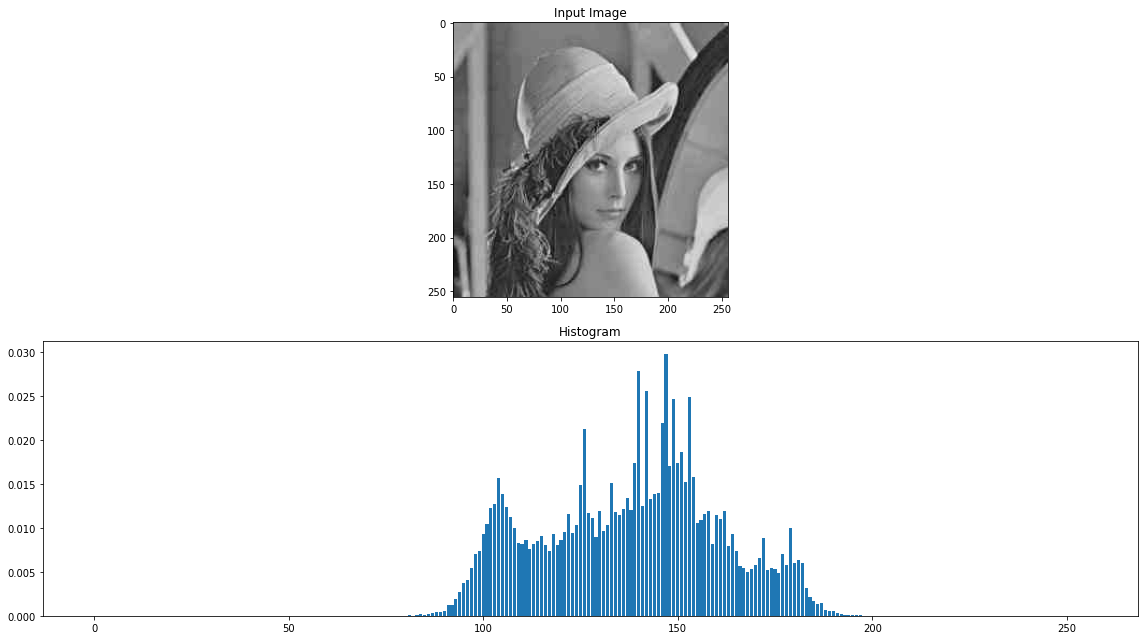

In [ ]:
lena_img = cv2.imread(lena, 0)
_, _ = histogram(lena_img, display=True)

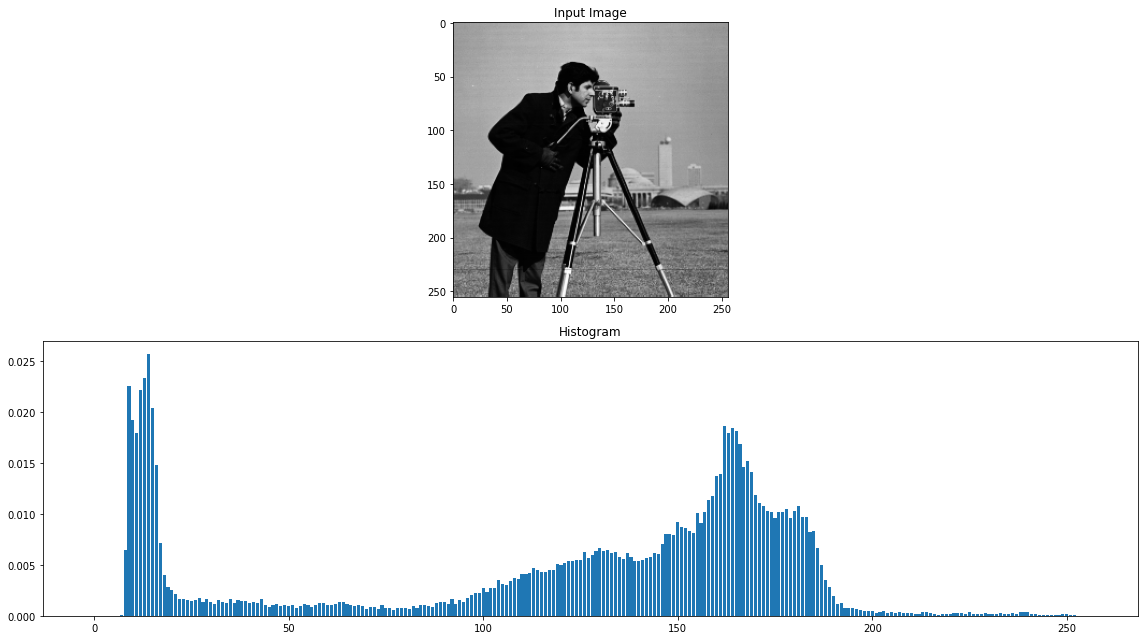

In [ ]:
photographer_img = cv2.imread(photographer, 0)
_, _ = histogram(photographer_img, display=True)

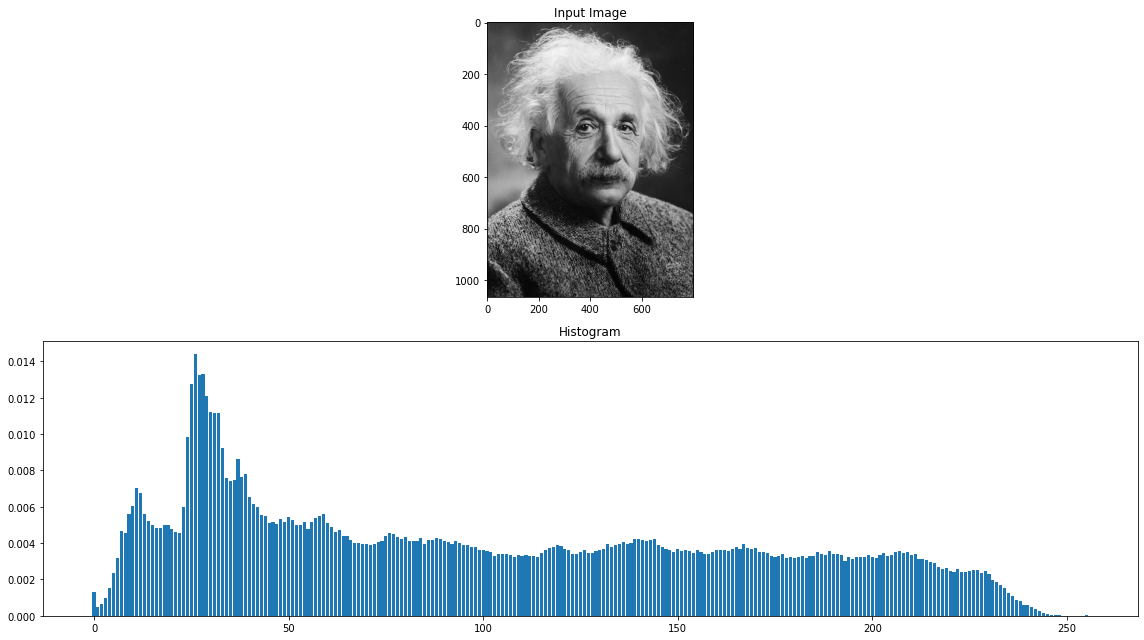

In [ ]:
einstein_img = cv2.imread(einstein, 0)
_, _ = histogram(einstein_img, True)

# **Histogram Equalization**

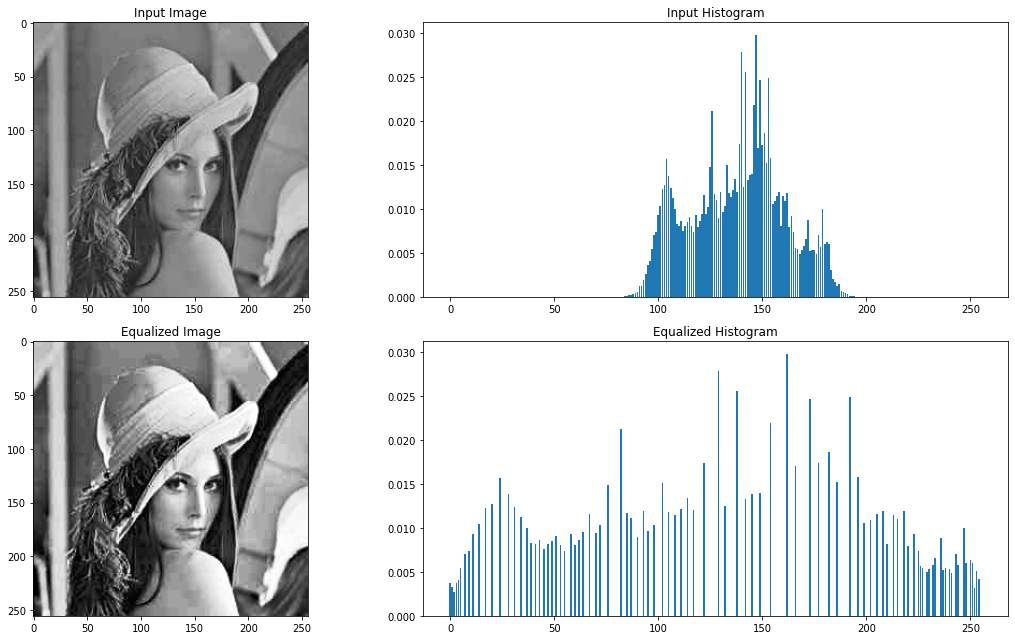

In [ ]:
_ = histogram_equalization(lena_img, display=True)

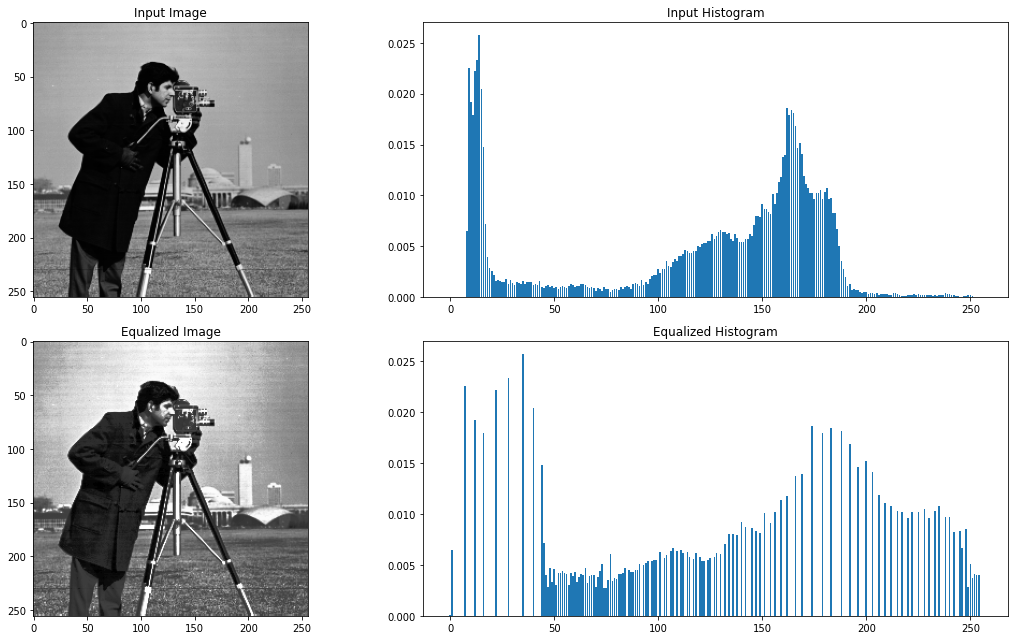

In [ ]:
_ = histogram_equalization(photographer_img, display=True)

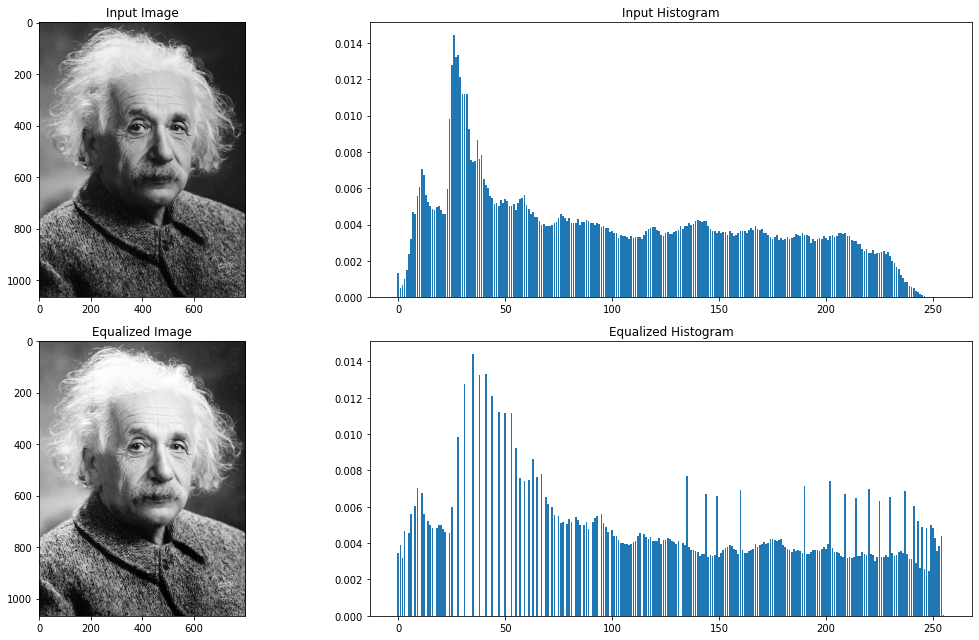

In [ ]:
_ = histogram_equalization(einstein_img, True)

# **Histogram Specification**

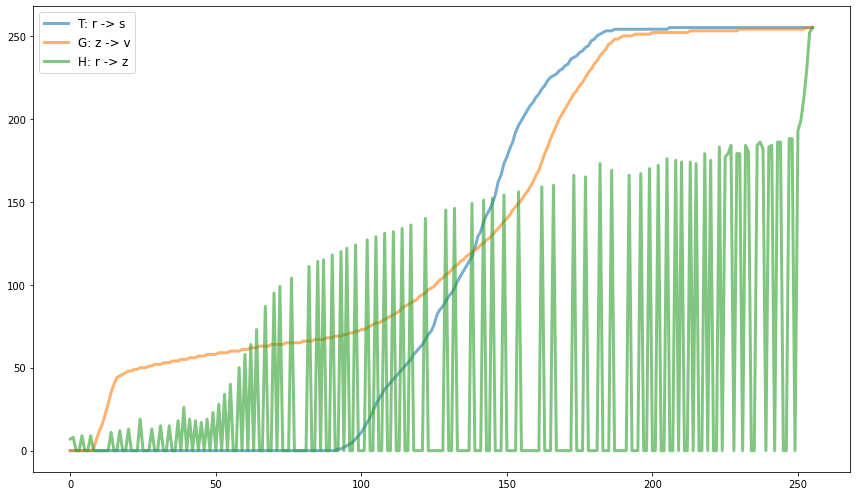

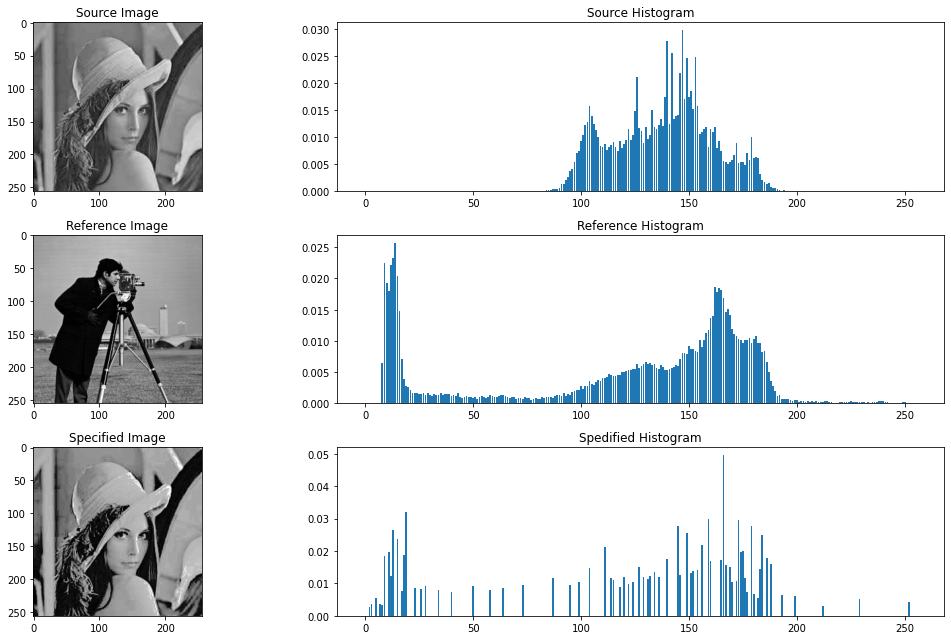

In [ ]:
# histogram specification
m, n = lena_img.shape
img2 = cv2.resize(photographer_img, (n, m))

_, _ = histogram_specification(lena_img, img2, True, True)

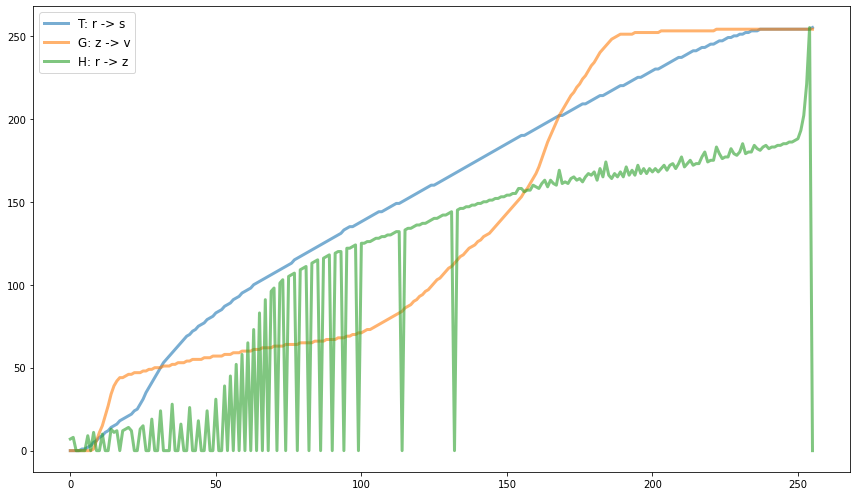

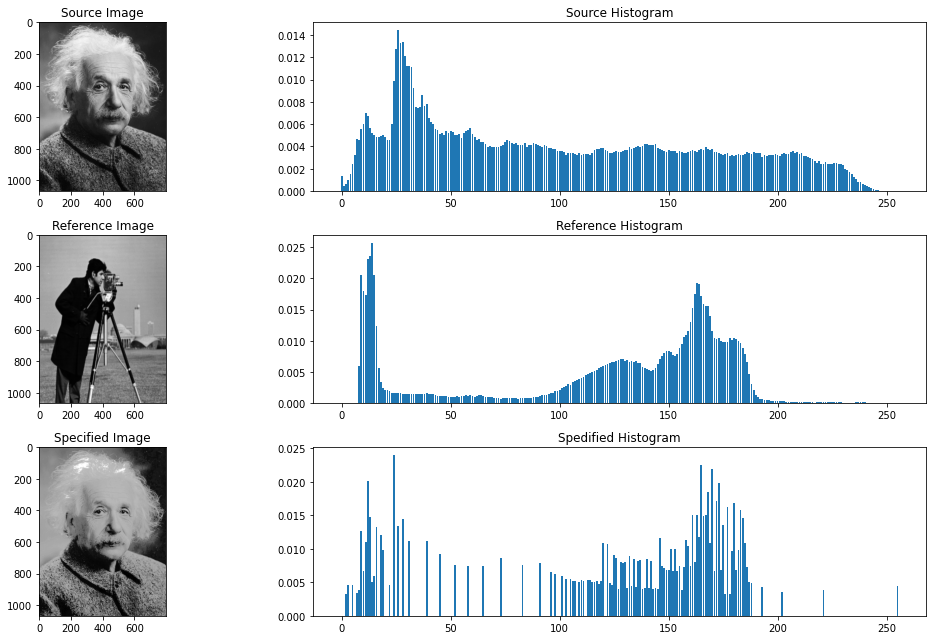

In [ ]:
# histogram specification
m, n = einstein_img.shape
img2 = cv2.resize(photographer_img, (n, m))

_, _ = histogram_specification(einstein_img, img2, True, True)

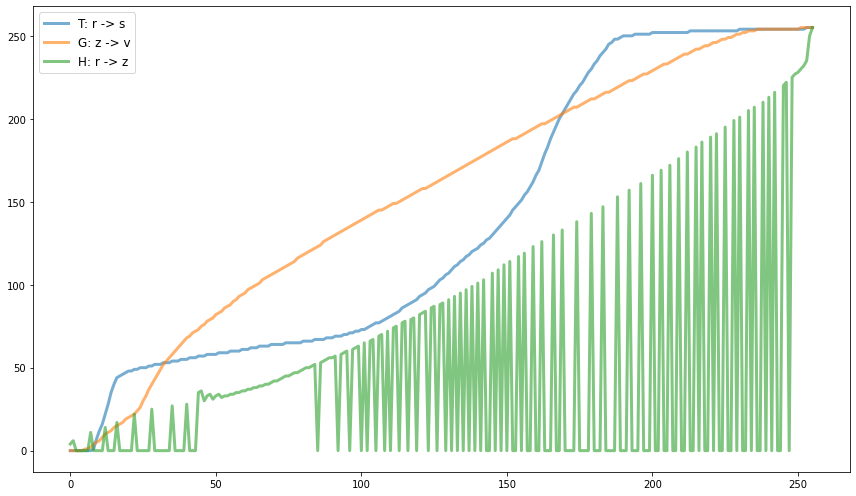

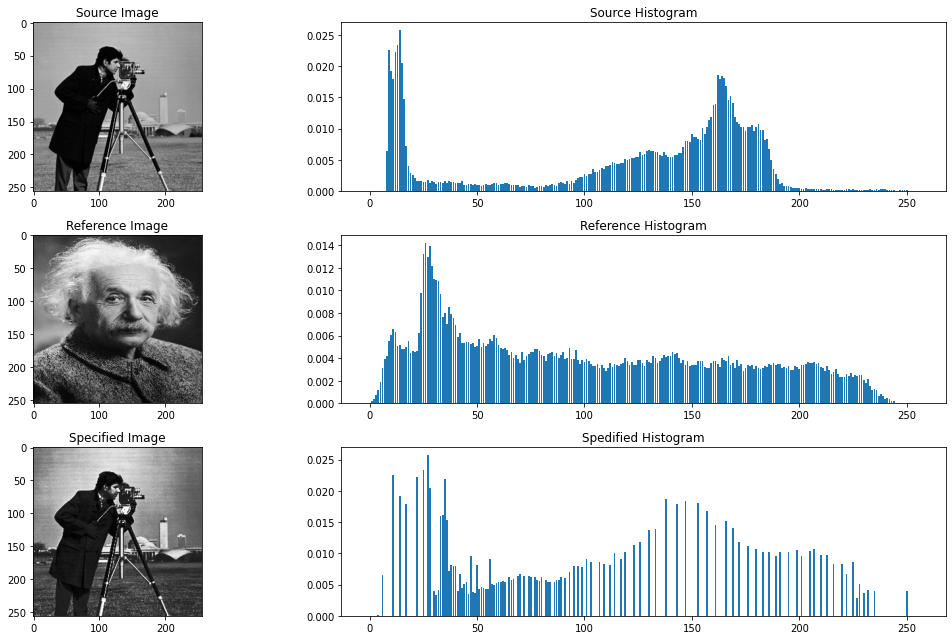

In [ ]:
# histogram specification
m, n = photographer_img.shape
img2 = cv2.resize(einstein_img, (n, m))

_, _ = histogram_specification(photographer_img, img2, True, True)